In [1]:
import sys
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyOffsetFrame, SkyCoord
import astropy.units as u
import numpy as np
from astropy.wcs import WCS
from astropy.io import fits
from scipy.ndimage import gaussian_filter
from minot.ClusterTools import map_tools
import pitszi
import minot

# Test with MINOT

===== Information relative to the grid sampling =====
   Grid size : 119 , 59 , 319
   Pixel size :      31.4     kpc ;     5.0      arcsec
   Fov size :  [   3741.5   ,   1855.0   ] kpc ; [   9.917    ,   4.917    ] arcmin
   L.o.S. resolution :         12.6     kpc
   Map center :   <SkyCoord (ICRS): (ra, dec) in deg
    (330., 50.)>
   k min/max projected :       0.001681  /  0.099160   1/arcsec
   k min/max projected :       0.000267  /  0.015769   1/kpc
   k min/max L.o.S. (eq.) :    0.001567  /  0.249216   1/arcsec
   k min/max L.o.S. :          0.000249  /  0.039632   1/kpc
   k max Nyquist :             0.098305   1/arcsec
   k max Nyquist :             0.015633   1/kpc
--- Check1 --- -0.0 0.0
(59, 119)


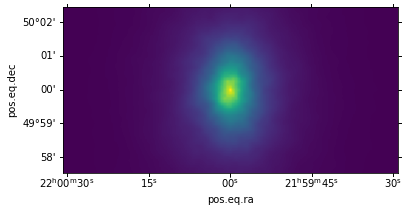

In [45]:
c = pitszi.Model(redshift=0.5, M500=1e15*u.Msun, silent=True)   
c.coord      = SkyCoord("22:00:00 +50:00:00", unit=(u.hourangle, u.deg), frame="icrs")
c.map_center = SkyCoord("22:00:00 +50:00:00", unit=(u.hourangle, u.deg), frame="icrs")
c.map_fov    = [10,5]*u.arcmin
c.map_reso   = 5*u.arcsec
c.los_reso   = 12.576462897253872*u.kpc#20*u.kpc

c.triaxiality = {'min_to_maj_axis_ratio': 0.6,
                 'int_to_maj_axis_ratio': 0.9,
                 'euler_angle1': 0*u.deg,
                 'euler_angle2': 0*u.deg,
                 'euler_angle3': 0*u.deg}

c.give_sampling_information()

img = c.get_sz_map(no_fluctuations=False)
header = c.get_map_header()
hdu = fits.PrimaryHDU(header=header)
hdu.data = img
hdu.header['EQUINOX'] = (2000., '[years]')
hdu.writeto('/Users/adam/Desktop/test.fits', overwrite=True)

ax = plt.subplot(projection=WCS(header))
plt.imshow(img)

print(img.shape)
#c.get_map_header()

In [4]:
q_a = 0.1
q_b = 0.3
angle1 = 0
angle2 = 0
angle3 = 0

# Tests

In [5]:
from scipy.spatial.transform import Rotation as R

Nx, Ny, Nz, proj_reso, proj_reso, los_reso = c.get_3dgrid()

ctr_xpix_vec = np.linspace(-Nx*proj_reso/2, Nx*proj_reso/2, Nx)
ctr_ypix_vec = np.linspace(-Ny*proj_reso/2, Ny*proj_reso/2, Ny)
ctr_zpix_vec = np.linspace(-Nz*los_reso/2,  Nz*los_reso/2,  Nz)

coord_x, coord_y, coord_z = np.meshgrid(ctr_xpix_vec, ctr_ypix_vec, ctr_zpix_vec, indexing='ij')
        
rot = R.from_euler('ZXZ', [angle1, angle2, angle3], degrees=True)
coordinates = np.stack((coord_x, coord_y, coord_z), axis=-1)
coordinates_reshape = coordinates.reshape(-1, 3)
rotated_coordinates = rot.apply(coordinates_reshape).reshape(coord_x.shape + (3,))

rot_coord_x = rotated_coordinates[:,:,:,0] / q_a
rot_coord_y = rotated_coordinates[:,:,:,1] / q_b
rot_coord_z = rotated_coordinates[:,:,:,2]
        
rad_grid = np.sqrt((rot_coord_x)**2 + (rot_coord_y)**2 + (rot_coord_z)**2)

Text(0.5, 1.0, 'yz plane')

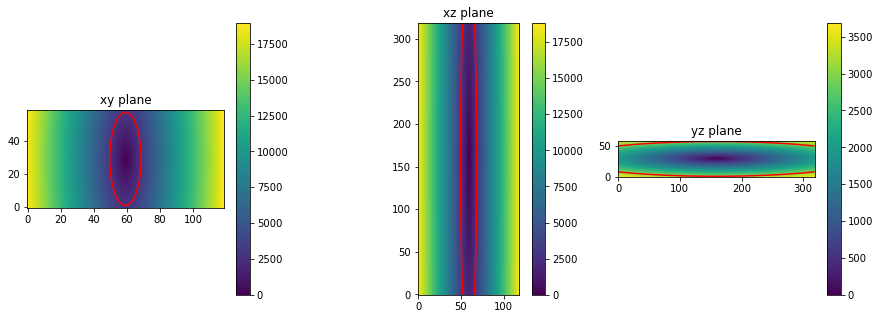

In [6]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(rad_grid[:,:,int(rad_grid.shape[2]/2)].T, origin='lower')
plt.colorbar()
plt.contour(rad_grid[:,:,int(rad_grid.shape[2]/2)].T, levels=[3000], colors='r')
plt.title('xy plane')

plt.subplot(1,3,2)
plt.imshow(rad_grid[:,int(rad_grid.shape[1]/2),:].T, origin='lower')
plt.colorbar()
plt.contour(rad_grid[:,int(rad_grid.shape[1]/2),:].T, levels=[3000], colors='r')
plt.title('xz plane')

plt.subplot(1,3,3)
plt.imshow(rad_grid[int(rad_grid.shape[0]/2),:,:], origin='lower')
plt.colorbar()
plt.contour(rad_grid[int(rad_grid.shape[0]/2),:,:], levels=[3000], colors='r')
plt.title('yz plane')